In [1]:
# Importing required libraries
import requests
import pandas as pd
import csv
import numpy as np
from itertools import permutations
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import math
from fbprophet.diagnostics import performance_metrics
from sklearn.model_selection import ParameterGrid
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import scipy.stats as sp
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_pacf

#from pmdarima.arima import auto_arima
import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

In [3]:
# Import data
df = pd.read_csv('../data/meteolytix_Saisonlogik_2021.csv', sep=';')
df.drop(columns=['Branch Number'], inplace=True)
df.columns = df.columns.str.replace(' ','_')

# Convert timestamp to datetime object
df['Sold_On']=pd.to_datetime(df['Sold_On'])
# Extract additional features from timestamp column
df = df.assign( 
    Year  = lambda x: x['Sold_On'].dt.year,
    Month = lambda x: x['Sold_On'].dt.month,
    Week  = lambda x: x['Sold_On'].dt.isocalendar().week,
    Day   = lambda x: x['Sold_On'].dt.dayofweek)

df["Amount_Sold"]=df["Amount_Sold"].str.replace(',','.')
df['Amount_Sold'] = pd.to_numeric(df['Amount_Sold'], errors='coerce')
df['Amount_Sold'] = df['Amount_Sold'].astype(int)

df=df.replace({'Amount_Delivered': {8224: 28}})
df=df.sort_values(by='Sold_On')
df=df.loc[df['Article_Number']==1]
df

,Sold_On,Article_Number,Amount_Sold,Amount_Delivered,Year,Month,Week,Day
0,2012-01-16,1,9,20,2012,1,3,0
1,2012-01-17,1,14,20,2012,1,3,1
2,2012-01-18,1,29,30,2012,1,3,2
3,2012-01-19,1,13,15,2012,1,3,3
4,2012-01-20,1,14,25,2012,1,3,4
...,...,...,...,...,...,...,...,...
5377,2021-04-10,1,48,50,2021,4,14,5
5380,2021-04-11,1,60,60,2021,4,14,6
5383,2021-04-12,1,55,55,2021,4,15,0
5386,2021-04-13,1,55,55,2021,4,15,1


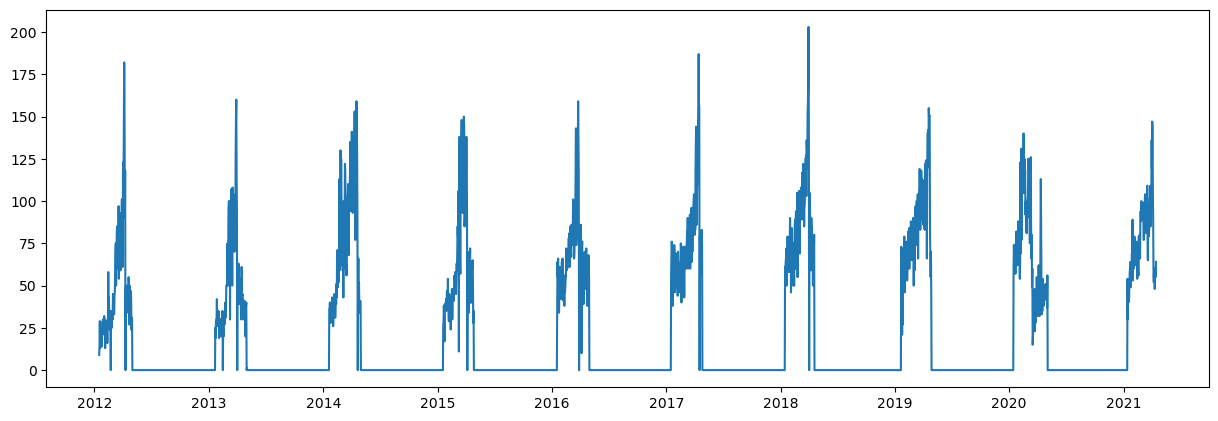

In [4]:
#setting easter holidays
holidays = pd.DataFrame({
  'holiday': 'Ostertage',
  'ds': pd.to_datetime([ '2012-04-04','2012-04-05','2012-04-06','2012-04-07','2012-04-08', 
                         '2013-03-27','2013-03-28','2013-03-29','2013-03-30','2013-03-31', 
                         '2014-04-16','2014-04-17','2014-04-18','2014-04-19','2014-04-20', 
                         '2015-04-01','2015-04-02','2015-04-03','2015-04-04','2015-04-05', 
                         '2016-03-23','2016-03-24','2016-03-25','2016-03-26','2016-03-27', 
                         '2017-04-12','2017-04-13','2017-04-14','2017-04-15','2017-04-16', 
                         '2018-03-28','2018-03-29','2018-03-30','2018-03-31','2018-04-01', 
                         '2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21', 
                         '2020-04-03','2020-04-04','2020-04-05','2020-04-06','2020-04-07', 
                         '2021-03-31','2021-04-01','2021-04-02','2021-04-03','2021-04-04', 
                         '2022-04-13','2022-04-14','2022-04-15','2022-04-16','2022-04-17']),
  'lower_window': 0,
  'upper_window': 1,
})

#imputing missing time periods with zeros
df = df.rename(columns={'Sold_On':'ds', 'Amount_Sold':'y'})
df.set_index(df.ds, inplace=True)
df_resampled=df.resample('D').sum().fillna(0)
plt.plot(df_resampled.index,df_resampled.y)
df_resampled=df_resampled.reset_index()

## Prediction of 2021 with holidays

In [5]:
#train-test-split & Format data for prophet model using ds and y
#df = df.rename(columns={'Sold_On':'ds', 'Amount_Sold':'y'})
split_date = '2021-01-01'
train = df_resampled.loc[df_resampled.ds <= split_date].copy()
test = df_resampled.loc[df_resampled.ds > split_date].copy()
df_train = train[['ds', 'y']]
df_test = test[['ds']]

# Fitting a Prophet model
model = Prophet(holidays=holidays)
#model.add_country_holidays(country_name='Germany')
model.fit(df_train)
prediction = model.predict(df_test)

#define period for which we want to forecast
#one year future forecast period (daily predictions)
index_1_year=pd.date_range(df_resampled['ds'].iloc[-1],freq='D',periods=365)
df_index_1_year=pd.DataFrame(index_1_year)
df_index_1_year.columns=['ds']
df_index_1_year['ds']=pd.to_datetime(df_index_1_year['ds'])
fcast=model.predict(df_index_1_year)

mean_absolute_error(test.y,prediction.yhat)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13.902308407276047

## Prediction without 2012/2013/2020

In [28]:
#train-test-split & Format data for prophet model using ds and y
#df = df.rename(columns={'Sold_On':'ds', 'Amount_Sold':'y'})
data1 = (df_resampled['ds'] >= '2012-01-01') & (df_resampled['ds'] <= '2019-12-31')
data2 = (df_resampled['ds'] >= '2021-01-01') & (df_resampled['ds'] <= '2021-05-30')
data1 = df_resampled.loc[data1]
data2 = df_resampled.loc[data2]
data = pd.concat([data1,data2])
data = data[data['ds'] >= '2014-01-01']

split_date = '2021-01-01'
train = data.loc[data.ds <= split_date].copy()
test = data.loc[data.ds > split_date].copy()
df_train = train[['ds', 'y']]
df_test = test[['ds']]

# Fitting a Prophet model
model = Prophet(holidays=holidays)
#model.add_country_holidays(country_name='Germany')
model.fit(df_train)
prediction = model.predict(df_test)

#define period for which we want to forecast
#one year future forecast period (daily predictions)
index_1_year=pd.date_range(df_resampled['ds'].iloc[-1],freq='D',periods=730)
df_index_1_year=pd.DataFrame(index_1_year)
df_index_1_year.columns=['ds']
df_index_1_year['ds']=pd.to_datetime(df_index_1_year['ds'])
fcast=model.predict(df_index_1_year)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


13.254599663708857

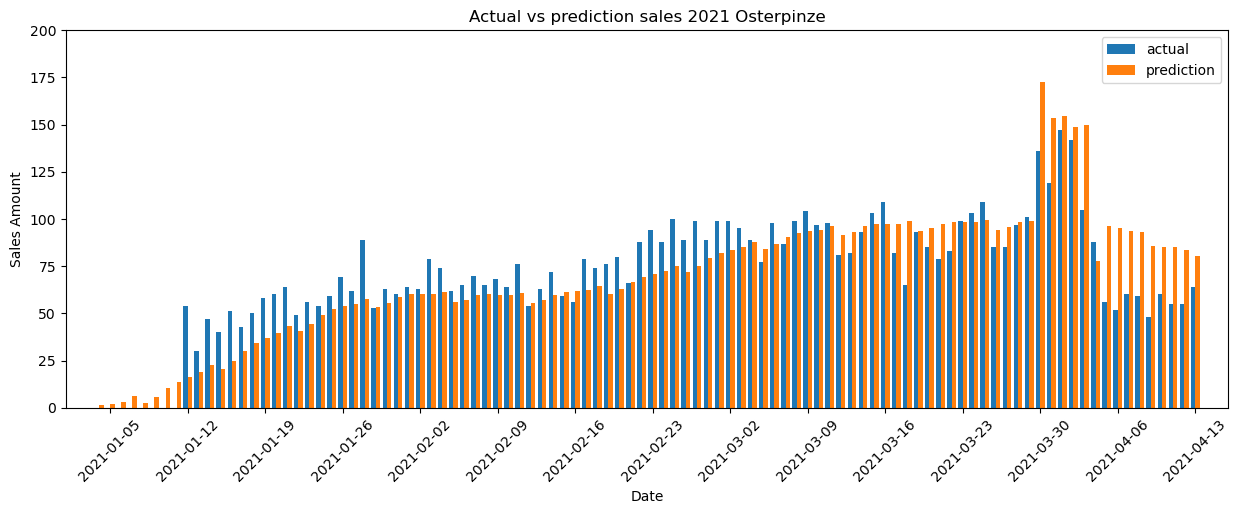

In [29]:
test = test.assign(YearDay=lambda x: x['ds'].dt.dayofyear)
test_2021 = test[['y', 'ds']]
test_2021 = test_2021.set_index('ds').sort_index()

prediction = prediction.assign(YearDay=lambda x: x['ds'].dt.dayofyear)
prediction_2021 = prediction[['yhat', 'ds']]
prediction_2021 = prediction_2021.set_index('ds').sort_index()

result_2021 = pd.concat([test_2021, prediction_2021], axis=1)
fmt_half_year = mdates.WeekdayLocator(byweekday=0,interval=1)
ax = result_2021.plot.bar(rot=45, width=0.8)
ax.xaxis.set_major_locator(fmt_half_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%2021-%m-%d'))
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xlim([0,105])
plt.ylim([0,200])
plt.xticks(rotation=45)
plt.gca().legend(('actual','prediction'))
plt.title("Actual vs prediction sales 2021 Osterpinze")
mean_absolute_error(test.y,prediction.yhat)

## HyperParameter Tuning using ParameterGrid

In [8]:
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [9]:
strt='2021-01-01'
end='2021-05-01'
model_parameters = pd.DataFrame(columns = ['MAE','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         yearly_seasonality = True,
                         holidays=holidays, 
                         interval_width=0.95)
    #train_model.add_country_holidays(country_name='Germany')
    train_model.fit(df_train)
    train_forecast = train_model.make_future_dataframe(periods=103, freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = data[(data['ds']>strt) & (data['ds']<=end)]
    MAE = mean_absolute_error(Actual['y'][11:],abs(test['yhat'][11:]))
    print('Mean Absolute Error(MAE)------------------------------------',MAE)
    model_parameters = model_parameters.append({'MAE':MAE,'Parameters':p},ignore_index=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 118.69618303024005
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.3407074150637
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 112.42979883290486
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.35187391104112
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 110.9553413768792
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.359639714944176
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 110.07827094292271
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.377071987670627
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 106.95023418302485
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.416944307260945
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 103.28121027262442
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.423285558756074
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 102.65047066331826
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.443461591494447
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 103.61397582101581
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.436198747129463
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 100.36124528060054
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.422819747260252
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 102.0002951677604
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.430299495989837
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 99.2817040660805
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.44233611528564
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 96.7028303624168
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.414345258100681
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 99.8897550108636
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.429350455696838
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 96.66920039327483
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.424292848734197
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 97.53325567845197
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.435519570731572
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 228.589892470174
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.458063229193485
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 224.33745924059468
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.513448202181678
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 215.9463123971182
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.529519115303456
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 191.03917430734126
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.523957639801798
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 185.90790372174493
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.51810754991864
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 180.59567125329642
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.605914903596465
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 163.7199257200836
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.50067051984402
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 156.89222248301476
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.557636206423346
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 157.00698614230944
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.511056919994456
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 146.24935600345407
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.528023395461704
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 148.70225785372273
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.60905468235093
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 144.81338125642355
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.583920207627404
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 142.83501353435625
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.52527433051592
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 143.70933343447018
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 13.530767506604644
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 136.5024879834631
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.591871226382354
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 202.20116872082244
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.598734271101318
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 201.21644327524106
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.677212179809887
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 209.91892987725402
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.697707694784585
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 181.0644174560819
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.6672029369869
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 174.03678025020199
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.734680552295176
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 178.77259398586367
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.74272572516109
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 163.73406150421954
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.694198550526233
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 160.3426208739678
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.758556668328552
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}
Mean Absolute Error(MAE)------------------------------------ 163.73583902201824
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.753425501536357
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 152.12012333634885
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.678986590784525
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 154.5736667032763
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.766017471347054
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 153.71750916143546
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.774438747283776
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 150.15416654359638
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.698771459334953
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 148.93099492033485
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.742628399059956
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 149.41698332624566
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.7630896884555
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 203.15855482453503
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.679856462444528
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 202.1140651996179
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.80919539823752
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 209.82658133297682
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.79053650397705
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 174.5599845840247
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.737824425659042
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 178.01826506107093
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.8383235130888
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 189.43178474155988
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.864070909718343
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 156.98969874934954
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.768422011462379
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 156.55182213467643
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.886037240504752
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 165.3945652382156
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.850648494881677
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 121.74280727516094
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.762167662005828
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 128.50357497397917
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.868064197583799
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 145.19133143402362
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.860722910840968
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 126.45760189911235
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.772422404609857
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 107.86644416244962
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.836305118490372
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 119.82550841135694
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.889898092932135
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 185.24447111970088
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.831005539752793
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 190.5414817577156
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.949124952145123
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 185.84251807678444
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.887195487492047
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 145.84599556175905
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.899331152177519
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 157.9333352263077
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.995750742633357
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 161.2567560504004
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.015599173520425
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 79.2409815255395
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.934342541650663
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 102.06953877820494
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.98484277389241
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 122.8653994932129
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.989630820014884
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 77.10391097425432
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.90493028749023
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 69.25163877083321
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.00061585933689
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 89.61968313175404
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.000697705797862
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 55.73422437043761
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 13.917172487297979
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 65.24651154905845
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 14.014377828204632
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Mean Absolute Error(MAE)------------------------------------ 76.14523104659379
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}
Mean Absolute Error(MAE)------------------------------------ 14.01694129263695


In [10]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.2,
 'holidays_prior_scale': 0.1,
 'n_changepoints': 100,
 'seasonality_mode': 'additive'}

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


12.714196660480637
0.19573024038197034


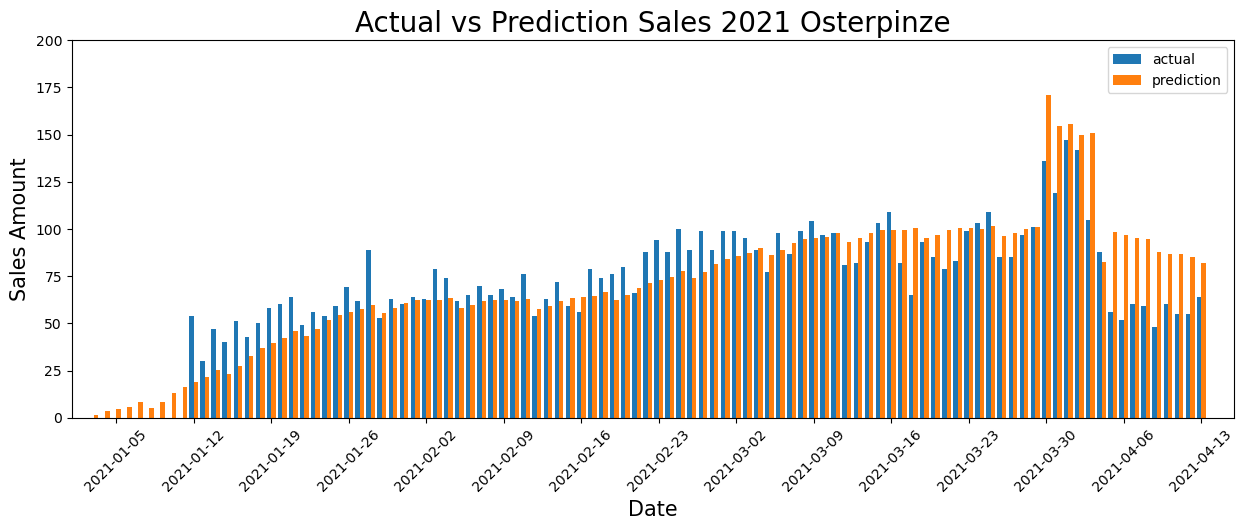

In [11]:
#train-test-split & Format data for prophet model using ds and y
#df = df.rename(columns={'Sold_On':'ds', 'Amount_Sold':'y'})
data1 = (df_resampled['ds'] >= '2012-01-01') & (df_resampled['ds'] <= '2019-12-31')
data2 = (df_resampled['ds'] >= '2021-01-01') & (df_resampled['ds'] <= '2021-05-30')
data1 = df_resampled.loc[data1]
data2 = df_resampled.loc[data2]
data = pd.concat([data1,data2])
data = data[data['ds'] >= '2014-01-01']

split_date = '2021-01-01'
train = data.loc[data.ds <= split_date].copy()
test = data.loc[data.ds > split_date].copy()
df_train = train[['ds', 'y']]
df_test = test[['ds']]

# Fitting a Prophet model
model = Prophet(holidays=holidays,
                changepoint_prior_scale= 0.2,
                holidays_prior_scale= 0.1,
                n_changepoints= 100,
                seasonality_mode= 'additive')
#model.add_country_holidays(country_name='Germany')
model.fit(df_train)
prediction = model.predict(df_test)

#define period for which we want to forecast
#one year future forecast period (daily predictions)
index_1_year=pd.date_range(df_resampled['ds'].iloc[-1],freq='D',periods=730)
df_index_1_year=pd.DataFrame(index_1_year)
df_index_1_year.columns=['ds']
df_index_1_year['ds']=pd.to_datetime(df_index_1_year['ds'])
fcast=model.predict(df_index_1_year)

test = test.assign(YearDay=lambda x: x['ds'].dt.dayofyear)
test_2021 = test[['y', 'ds']]
test_2021 = test_2021.set_index('ds').sort_index()

prediction = prediction.assign(YearDay=lambda x: x['ds'].dt.dayofyear)
prediction_2021 = prediction[['yhat', 'ds']]
prediction_2021 = prediction_2021.set_index('ds').sort_index()

result_2021 = pd.concat([test_2021, prediction_2021], axis=1)
fmt_half_year = mdates.WeekdayLocator(byweekday=0,interval=1)
ax = result_2021.plot.bar(rot=45, width=0.8)
ax.xaxis.set_major_locator(fmt_half_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%2021-%m-%d'))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Sales Amount', fontsize=15)
plt.xlim([0,105])
plt.ylim([0,200])
plt.xticks(rotation=45)
plt.gca().legend(('actual','prediction'))
plt.title("Actual vs Prediction Sales 2021 Osterpinze", fontsize=20)
#plt.rc('xtick', labelsize=20) 
#plt.rc('ytick', labelsize=20)
print(mean_absolute_error(test.y,prediction.yhat))
print(mean_absolute_percentage_error(test.y[11:],prediction.yhat[11:]))

## Sales Forecast 2022

Text(0.5, 0, 'Date')

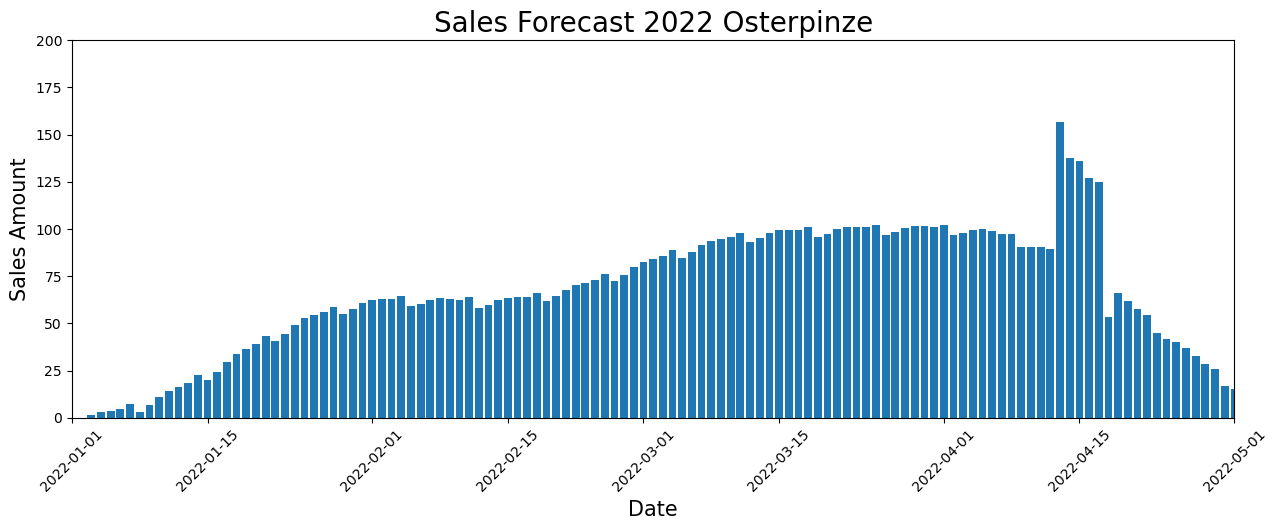

In [12]:
fcast_2022=(fcast['ds'] >= '2022-01-01') & (fcast['ds'] <= '2022-05-01')
fcast_2022 = fcast.loc[fcast_2022]
ax=plt.bar(fcast_2022.ds,fcast_2022.yhat, width=0.8)
plt.ylim([0,200])
plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-05-01'))
plt.title('Sales Forecast 2022 Osterpinze', fontsize=20)
plt.xticks(rotation=45)
plt.ylabel('Sales Amount', fontsize=15)
plt.xlabel('Date', fontsize=15)

In [13]:
fcast_2022.loc[fcast_2022.ds<='2022-05-01'].yhat.sum()

8080.944343001492

## Prediction of ratio deliveries to sold

In [14]:
df_resampled_fcast=df_resampled.rename(columns={'y':'Amount_Sold'})
df_resampled_fcast['Ratio_DelSol']=df_resampled_fcast.Amount_Delivered/df_resampled_fcast.Amount_Sold
df_resampled_fcast=df_resampled_fcast.rename(columns={'Ratio_DelSol':'y'})

#predict ratio
data1 = (df_resampled_fcast['ds'] >= '2012-01-01') & (df_resampled_fcast['ds'] <= '2019-12-31')
data2 = (df_resampled_fcast['ds'] >= '2021-01-01') & (df_resampled_fcast['ds'] <= '2021-05-30')
data1 = df_resampled_fcast.loc[data1]
data2 = df_resampled_fcast.loc[data2]
data = pd.concat([data1,data2])
data = data[data['ds'] >= '2014-01-01']

split_date = '2021-01-01'
train = data.loc[data.ds <= split_date].copy()
test = data.loc[data.ds > split_date].copy()
df_train = train[['ds', 'y']]
df_test = test[['ds']]

# Fitting a Prophet model
model = Prophet(holidays=holidays)
model.add_country_holidays(country_name='Germany')
model.fit(df_train)
prediction_ratio = model.predict(df_test)

#define period for which we want to forecast
#one year future forecast period (daily predictions)
index_1_year=pd.date_range(df_resampled['ds'].iloc[-1],freq='D',periods=730)
df_index_1_year=pd.DataFrame(index_1_year)
df_index_1_year.columns=['ds']
df_index_1_year['ds']=pd.to_datetime(df_index_1_year['ds'])
fcast_ratio=model.predict(df_index_1_year)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0.10559764239299194

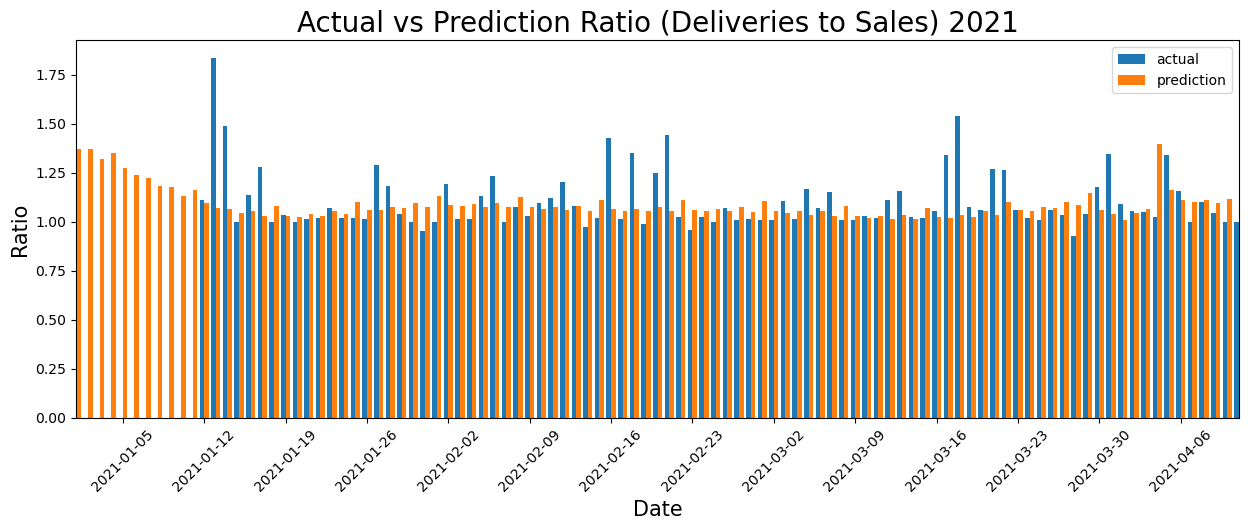

In [15]:
test = test.assign(YearDay=lambda x: x['ds'].dt.dayofyear)
test_2021 = test[['YearDay', 'y']]
test_2021 = test_2021.set_index('YearDay').sort_index()

prediction_ratio = prediction_ratio.assign(YearDay=lambda x: x['ds'].dt.dayofyear)
prediction_ratio = prediction_ratio[['YearDay', 'yhat']]
prediction_ratio = prediction_ratio.set_index('YearDay').sort_index()

result_2021 = pd.concat([test_2021, prediction_ratio], axis=1)
fmt_half_year = mdates.WeekdayLocator(byweekday=0,interval=1)
ax = result_2021.plot.bar(rot=45, width=0.8)
ax.xaxis.set_major_locator(fmt_half_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%2021-%m-%d'))
plt.xlabel('Date', fontsize=15)
plt.ylabel('Ratio', fontsize=15)
plt.xlim([0,100])
#plt.ylim([0,200])
plt.xticks(rotation=45)
plt.gca().legend(('actual','prediction'))
plt.title("Actual vs Prediction Ratio (Deliveries to Sales) 2021", fontsize=20)
mean_absolute_error(test_2021[11:],prediction_ratio[11:])

## Ratio Forecast 2022

In [16]:
fcast_2022_ratio=(fcast_ratio['ds'] >= '2022-01-01') & (fcast_ratio['ds'] <= '2022-05-01')
fcast_2022_ratio = fcast_ratio.loc[fcast_2022_ratio]

overdelivery=fcast_2022_ratio.loc[(fcast_2022_ratio.yhat>=1.05)]
underdelivery=fcast_2022_ratio.loc[(fcast_2022_ratio.yhat<=0.99)]
onpoint=fcast_2022_ratio.loc[(fcast_2022_ratio.yhat>0.99)&(fcast_2022_ratio.yhat<1.05)]

overdelivery['rate']=(fcast_2022_ratio.loc[(fcast_2022_ratio.yhat>1)].yhat-1)*100
underdelivery['rate']=(fcast_2022_ratio.loc[(fcast_2022_ratio.yhat<1)].yhat-1)*100
onpoint['rate']=((fcast_2022_ratio.loc[(fcast_2022_ratio.yhat>0.99)&(fcast_2022_ratio.yhat<1.1)]).yhat-1)*100

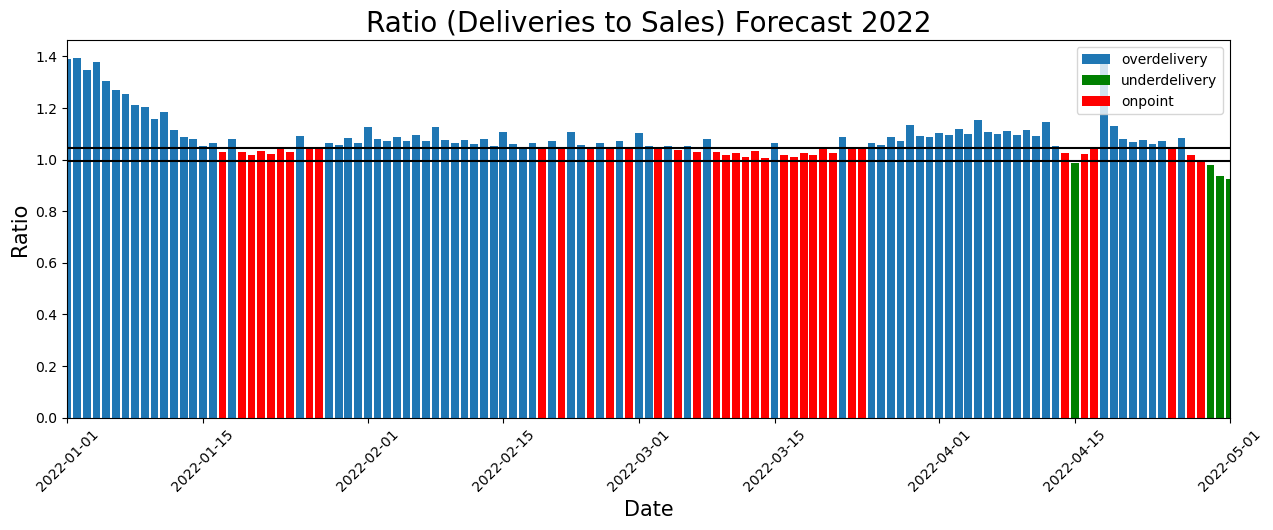

In [17]:
plt.bar(overdelivery.ds,overdelivery.yhat, label='overdelivery')
plt.bar(underdelivery.ds,underdelivery.yhat, label='underdelivery', color='g')
plt.bar(onpoint.ds,onpoint.yhat, label='onpoint',color='r')
plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-05-01'))
plt.legend(loc="upper right")
plt.title('Ratio (Deliveries to Sales) Forecast 2022', fontsize=20)
plt.ylabel('Ratio', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xticks(rotation=45)
plt.axhline(y=0.995, color='k', linestyle='-')
plt.axhline(y=1.045, color='k', linestyle='-')

(array([18993., 19007., 19024., 19038., 19052., 19066., 19083., 19097.,
        19113.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

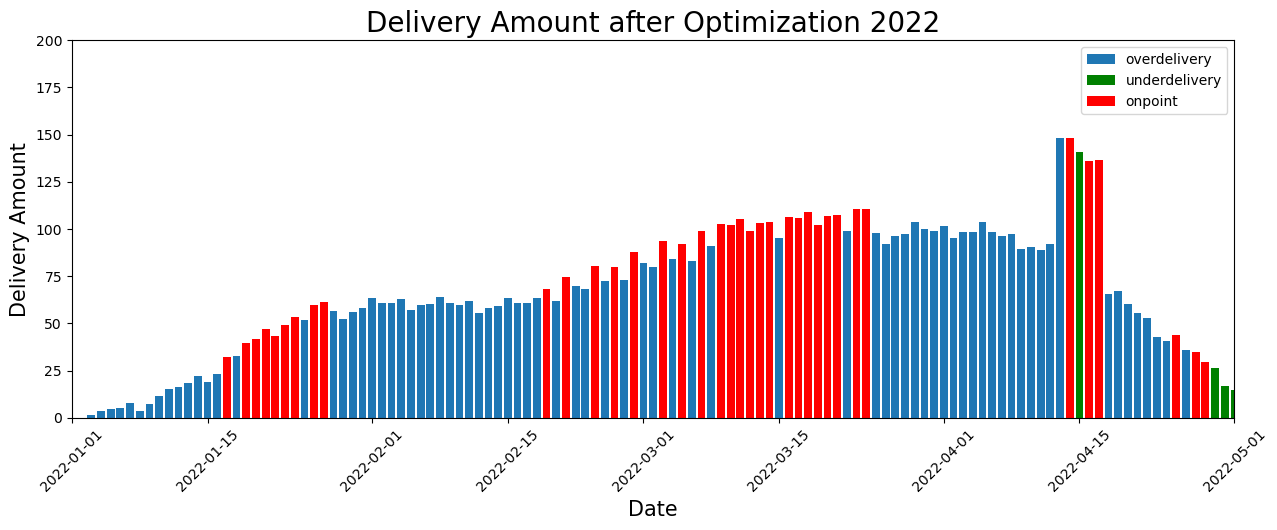

In [18]:
plt.bar(fcast_2022.ds,(overdelivery.yhat*0.9)*fcast_2022.yhat,label='overdelivery')
plt.bar(fcast_2022.ds,(underdelivery.yhat*1.05)*fcast_2022.yhat,label='underdelivery', color='g')
plt.bar(fcast_2022.ds,(onpoint.yhat*1.05)*fcast_2022.yhat,label='onpoint',color='r')
plt.legend(loc="upper right")
plt.ylim(0,200)
plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-05-01'))
plt.title('Delivery Amount after Optimization 2022', fontsize=20)
plt.ylabel('Delivery Amount', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.xticks(rotation=45)

## Component Analysis

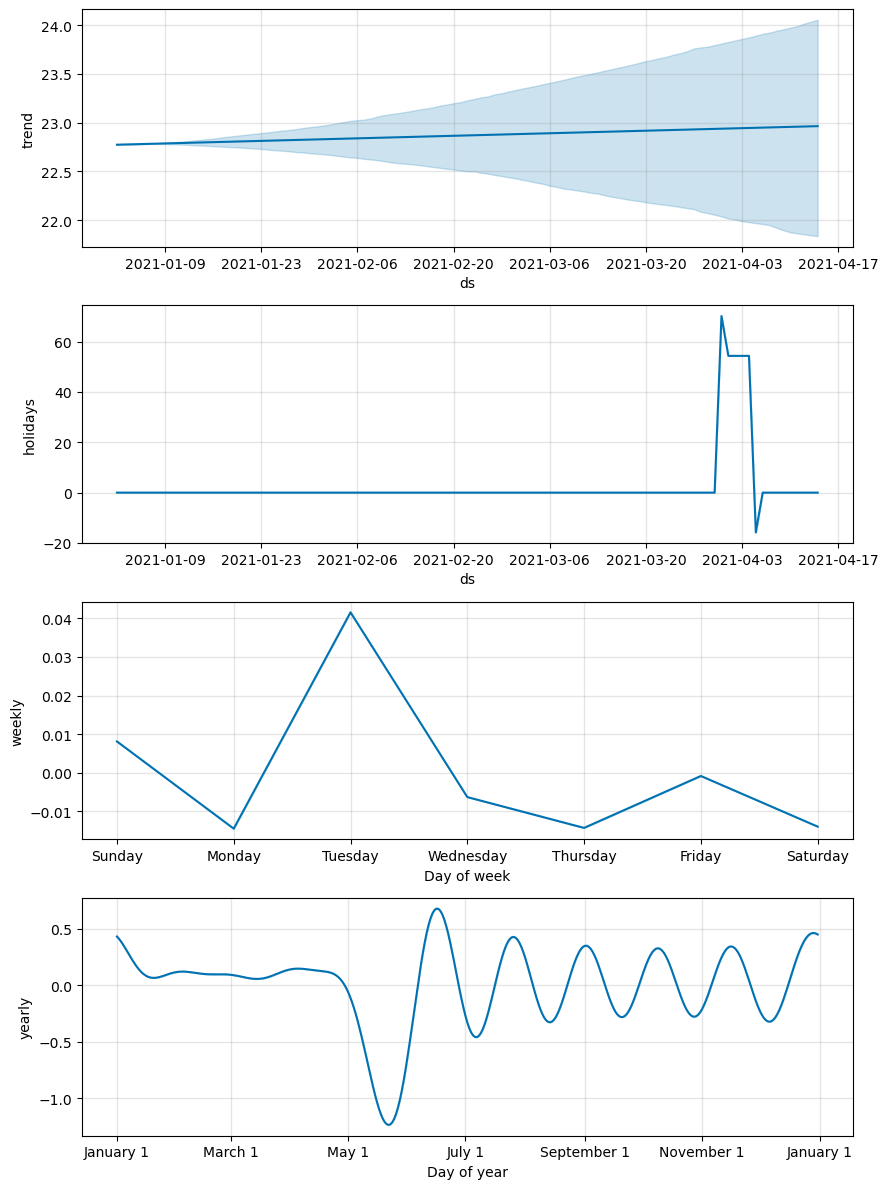

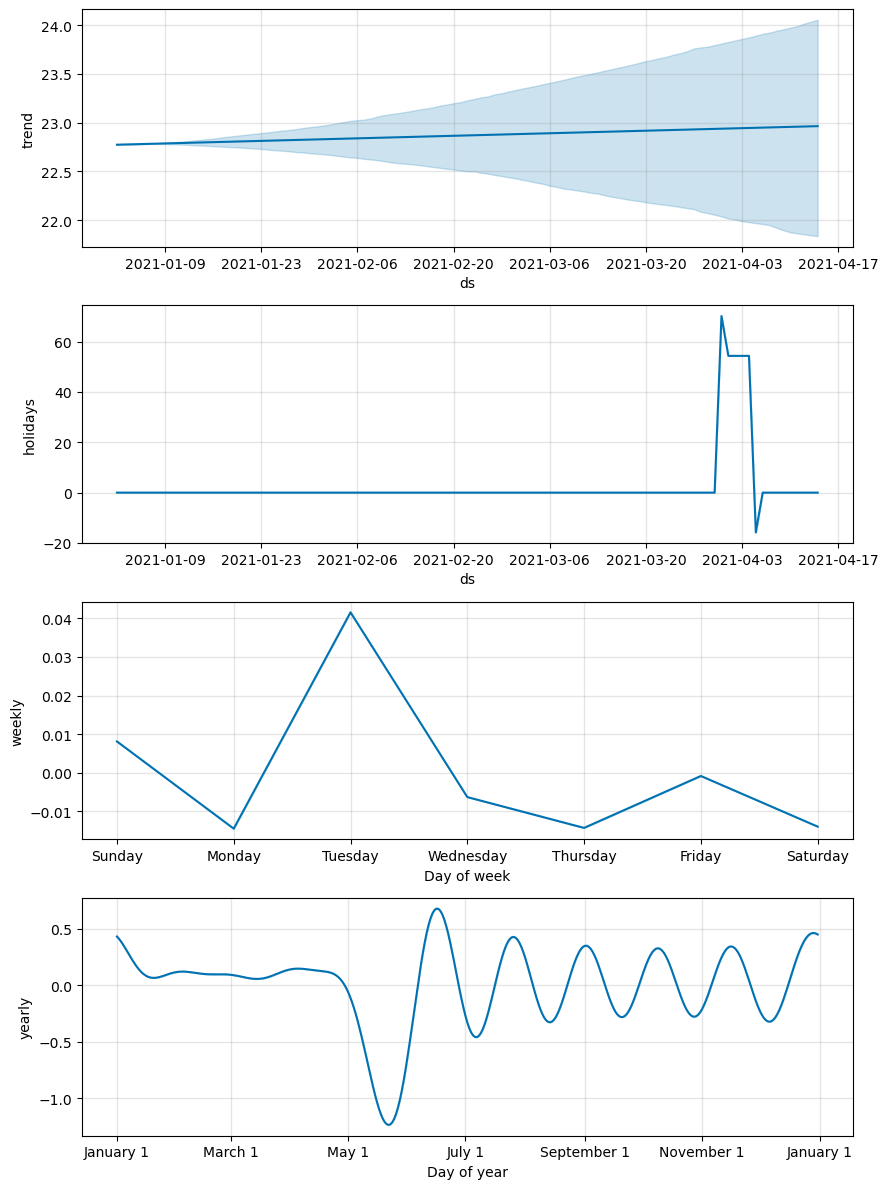

In [19]:
model.plot_components(prediction)

## Profit Calculation

In [30]:
# Assumed Selling Prices
Sell_Price_Article_1 = 1.4
Sell_Price_Article_2 = 1.4
Sell_Price_Article_3 = 1.4

# Assumed Total Production Costs: 8% Location rental, 
# 17% Production, 20% Personal -> 45 %. 1.4 * 0.45 = 0.63
Prod_Cost_Article_1 = 0.63
Prod_Cost_Article_2 = 0.63
Prod_Cost_Article_3 = 0.63

# Assumed increase of Sellings
Underdelivery_increase = 1.05

# Assumed decrease of Overdeliverys
Overdelivery_decrease = 1.1

In [31]:
a=pd.concat([fcast_2022.yhat,fcast_2022_ratio.yhat], axis=1)
a.columns = ['sales', 'ratio']
a=a.loc[a.ratio<1.05]
b=pd.concat([fcast_2022.yhat,fcast_2022_ratio.yhat], axis=1)
b.columns = ['sales', 'ratio']
b=b.loc[b.ratio>=1.05]

In [32]:
#create amount_sold/amount_delivered frame for actuals of 2021
data_actual={'Amount_Sold':[test.y.sum()],
             'Amount_Delivered':[test.Amount_Delivered.sum()]}
df_actual=pd.DataFrame(data_actual)

#create amount_sold/amount_delivered frame for predictions of 2021
data_prediction={'Amount_Sold':[prediction.yhat.sum()],
             'Amount_Delivered':[test.Amount_Delivered.sum()]}
df_prediction=pd.DataFrame(data_prediction)

#create amount_sold/amount_delivered frame for predictions of 2022
data_fcast={'Amount_Sold':[fcast_2022.yhat.sum()],
             'Amount_Delivered':[((overdelivery.yhat)*fcast_2022.yhat).sum()+((underdelivery.yhat)*fcast_2022.yhat).sum()+((onpoint.yhat)*fcast_2022.yhat).sum()]}
df_fcast=pd.DataFrame(data_fcast)

#create amount_sold/amount_delivered frame for optimized predictions of 2022
data_fcast_opt={'Amount_Sold':[fcast_2022.yhat.sum()],
                              #a.sales.sum()*1.05+b.sales.sum(),
             'Amount_Delivered':[((overdelivery.yhat*0.9)*fcast_2022.yhat).sum()+((underdelivery.yhat*1.05)*fcast_2022.yhat).sum()+((onpoint.yhat*1.05)*fcast_2022.yhat).sum()]}
df_fcast_opt=pd.DataFrame(data_fcast_opt)

#concat frames
df_Total=pd.concat([df_actual,df_prediction,df_fcast,df_fcast_opt], axis=0)
df_Total=df_Total.round(2)
df_Total['index']=['Actual_2021','Prediction_2021','Forecast_2022','Forecast_2022_opt']
df_Total.set_index('index', inplace=True)
df_Total

,Amount_Sold,Amount_Delivered
index,,
Actual_2021,7109.00,7753.00
Prediction_2021,6994.46,7753.00
Forecast_2022,8080.94,8610.44
Forecast_2022_opt,8080.94,8221.45


In [33]:
#calculation for actuals of 2021
df_actual['Amount_Discarded']=df_actual['Amount_Delivered']-df_actual['Amount_Sold']
df_actual['Discard_Rate']=df_actual['Amount_Delivered']/df_actual['Amount_Sold']
df_actual['Sell_Price']=[Sell_Price_Article_1]
df_actual['Prod_Cost'] =[Prod_Cost_Article_1] 
df_actual['Discarded']=df_actual['Amount_Discarded']*df_actual['Prod_Cost']
df_actual['Revenue']=df_actual['Amount_Sold']*df_actual['Sell_Price']
df_actual['Cost']=df_actual['Amount_Delivered']*df_actual['Prod_Cost']
df_actual['Profit']=df_actual['Revenue']-df_actual['Cost']
df_actual['Profitability']=df_actual['Profit']/df_actual['Cost']

df_actual = df_actual.transpose()
df_actual.index.name = None


df_actual["Total"] = df_actual.sum(axis = 1, skipna = True)
df_actual["Unit"] = ['[-]','[-]','[-]','[-]','[€]','[€]','[€]','[€]','[€]','[€]','[-]']
df_actual.Total.Profitability = df_actual.Total.Profitability / 3
df_actual.Total.Discard_Rate = df_actual.Total.Discard_Rate / 3
df_actual.Total.Sell_Price = df_actual.Total.Sell_Price / 3
df_actual.Total.Prod_Cost = df_actual.Total.Prod_Cost / 3

df_actual=df_actual.round(2)

df_actual.head(20)

,0,Total,Unit
Amount_Sold,7109.00,7109.00,[-]
Amount_Delivered,7753.00,7753.00,[-]
Amount_Discarded,644.00,644.00,[-]
Discard_Rate,1.09,0.36,[-]
Sell_Price,1.40,0.47,[€]
Prod_Cost,0.63,0.21,[€]
Discarded,405.72,405.72,[€]
Revenue,9952.60,9952.60,[€]
Cost,4884.39,4884.39,[€]
Profit,5068.21,5068.21,[€]


In [34]:
#calculation for prediction of 2021
df_prediction['Amount_Discarded']=df_prediction['Amount_Delivered']-df_prediction['Amount_Sold']
df_prediction['Discard_Rate']=df_prediction['Amount_Delivered']/df_prediction['Amount_Sold']
df_prediction['Sell_Price']=[Sell_Price_Article_1]
df_prediction['Prod_Cost'] =[Prod_Cost_Article_1] 
df_prediction['Discarded']=df_prediction['Amount_Discarded']*df_prediction['Prod_Cost']
df_prediction['Revenue']=df_prediction['Amount_Sold']*df_prediction['Sell_Price']
df_prediction['Cost']=df_prediction['Amount_Delivered']*df_prediction['Prod_Cost']
df_prediction['Profit']=df_prediction['Revenue']-df_prediction['Cost']
df_prediction['Profitability']=df_prediction['Profit']/df_prediction['Cost']

df_prediction = df_prediction.transpose()
df_prediction.index.name = None


df_prediction["Total"] = df_prediction.sum(axis = 1, skipna = True)
df_prediction["Unit"] = ['[-]','[-]','[-]','[-]','[€]','[€]','[€]','[€]','[€]','[€]','[-]']
df_prediction.Total.Profitability = df_prediction.Total.Profitability / 3
df_prediction.Total.Discard_Rate = df_prediction.Total.Discard_Rate / 3
df_prediction.Total.Sell_Price = df_prediction.Total.Sell_Price / 3
df_prediction.Total.Prod_Cost = df_prediction.Total.Prod_Cost / 3

df_prediction=df_prediction.round(2)

df_prediction.head(20)

,0,Total,Unit
Amount_Sold,6994.46,6994.46,[-]
Amount_Delivered,7753.00,7753.00,[-]
Amount_Discarded,758.54,758.54,[-]
Discard_Rate,1.11,0.37,[-]
Sell_Price,1.40,0.47,[€]
Prod_Cost,0.63,0.21,[€]
Discarded,477.88,477.88,[€]
Revenue,9792.24,9792.24,[€]
Cost,4884.39,4884.39,[€]
Profit,4907.85,4907.85,[€]


In [35]:
#calculation for forecast of 2022
df_fcast['Amount_Discarded']=df_fcast['Amount_Delivered']-df_fcast['Amount_Sold']
df_fcast['Discard_Rate']=df_fcast['Amount_Delivered']/df_fcast['Amount_Sold']
df_fcast['Sell_Price']=[Sell_Price_Article_1]
df_fcast['Prod_Cost'] =[Prod_Cost_Article_1] 
df_fcast['Discarded']=df_fcast['Amount_Discarded']*df_fcast['Prod_Cost']
df_fcast['Revenue']=df_fcast['Amount_Sold']*df_fcast['Sell_Price']
df_fcast['Cost']=df_fcast['Amount_Delivered']*df_fcast['Prod_Cost']
df_fcast['Profit']=df_fcast['Revenue']-df_fcast['Cost']
df_fcast['Profitability']=df_fcast['Profit']/df_fcast['Cost']

df_fcast = df_fcast.transpose()
df_fcast.index.name = None


df_fcast["Total"] = df_fcast.sum(axis = 1, skipna = True)
df_fcast["Unit"] = ['[-]','[-]','[-]','[-]','[€]','[€]','[€]','[€]','[€]','[€]','[-]']
df_fcast.Total.Profitability = df_fcast.Total.Profitability / 3
df_fcast.Total.Discard_Rate = df_fcast.Total.Discard_Rate / 3
df_fcast.Total.Sell_Price = df_fcast.Total.Sell_Price / 3
df_fcast.Total.Prod_Cost = df_fcast.Total.Prod_Cost / 3

df_fcast=df_fcast.round(2)

df_fcast.head(20)

,0,Total,Unit
Amount_Sold,8080.94,8080.94,[-]
Amount_Delivered,8610.44,8610.44,[-]
Amount_Discarded,529.50,529.50,[-]
Discard_Rate,1.07,0.36,[-]
Sell_Price,1.40,0.47,[€]
Prod_Cost,0.63,0.21,[€]
Discarded,333.58,333.58,[€]
Revenue,11313.32,11313.32,[€]
Cost,5424.58,5424.58,[€]
Profit,5888.74,5888.74,[€]


In [36]:
#calculation for forecast 2022 optimized
df_fcast_opt['Amount_Discarded']=df_fcast_opt['Amount_Delivered']-df_fcast_opt['Amount_Sold']
df_fcast_opt['Discard_Rate']=df_fcast_opt['Amount_Delivered']/df_fcast_opt['Amount_Sold']
df_fcast_opt['Sell_Price']=[Sell_Price_Article_1]
df_fcast_opt['Prod_Cost'] =[Prod_Cost_Article_1] 
df_fcast_opt['Discarded']=df_fcast_opt['Amount_Discarded']*df_fcast_opt['Prod_Cost']
df_fcast_opt['Revenue']=df_fcast_opt['Amount_Sold']*df_fcast_opt['Sell_Price']
df_fcast_opt['Cost']=df_fcast_opt['Amount_Delivered']*df_fcast_opt['Prod_Cost']
df_fcast_opt['Profit']=df_fcast_opt['Revenue']-df_fcast_opt['Cost']
df_fcast_opt['Profitability']=df_fcast_opt['Profit']/df_fcast_opt['Cost']

df_fcast_opt = df_fcast_opt.transpose()
df_fcast_opt.index.name = None


df_fcast_opt["Total"] = df_fcast_opt.sum(axis = 1, skipna = True)
df_fcast_opt["Unit"] = ['[-]','[-]','[-]','[-]','[€]','[€]','[€]','[€]','[€]','[€]','[-]']
df_fcast_opt.Total.Profitability = df_fcast_opt.Total.Profitability / 3
df_fcast_opt.Total.Discard_Rate = df_fcast_opt.Total.Discard_Rate / 3
df_fcast_opt.Total.Sell_Price = df_fcast_opt.Total.Sell_Price / 3
df_fcast_opt.Total.Prod_Cost = df_fcast_opt.Total.Prod_Cost / 3

df_fcast_opt=df_fcast_opt.round(2)

df_fcast_opt.head(20)

,0,Total,Unit
Amount_Sold,8080.94,8080.94,[-]
Amount_Delivered,8221.45,8221.45,[-]
Amount_Discarded,140.50,140.50,[-]
Discard_Rate,1.02,0.34,[-]
Sell_Price,1.40,0.47,[€]
Prod_Cost,0.63,0.21,[€]
Discarded,88.52,88.52,[€]
Revenue,11313.32,11313.32,[€]
Cost,5179.51,5179.51,[€]
Profit,6133.81,6133.81,[€]


In [38]:
df_Total_art1=pd.concat([df_actual[df_actual.columns[0]],df_prediction[df_prediction.columns[0]],
                         df_fcast[df_fcast.columns[0]], df_fcast_opt[df_fcast_opt.columns[0]],df_fcast_opt.Unit], axis=1)
df_Total_art1.columns = ['Actual_2021','Prediction_2021','Forecast_2022','Forecast_2022_opt','Unit']
df_Total_art1

,Actual_2021,Prediction_2021,Forecast_2022,Forecast_2022_opt,Unit
Amount_Sold,7109.00,6994.46,8080.94,8080.94,[-]
Amount_Delivered,7753.00,7753.00,8610.44,8221.45,[-]
Amount_Discarded,644.00,758.54,529.50,140.50,[-]
Discard_Rate,1.09,1.11,1.07,1.02,[-]
Sell_Price,1.40,1.40,1.40,1.40,[€]
Prod_Cost,0.63,0.63,0.63,0.63,[€]
Discarded,405.72,477.88,333.58,88.52,[€]
Revenue,9952.60,9792.24,11313.32,11313.32,[€]
Cost,4884.39,4884.39,5424.58,5179.51,[€]
Profit,5068.21,4907.85,5888.74,6133.81,[€]
